<a href="https://colab.research.google.com/github/KirillR911/ProHac4.0ACMChamps/blob/master/Preproc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [0]:
config_path='yolov3.cfg'
weights_path='yolov3.weights'
class_path='coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = load_classes(class_path)
Tensor = torch.cuda.FloatTensor


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [7]:
!wget https://pjreddie.com/media/files/yolov3.weights


--2019-11-17 01:16:18--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.1’

yolov3.weights.1    100%[===================>] 236.52M  1.82MB/s    in 2m 33s  

2019-11-17 01:18:52 (1.54 MB/s) - ‘yolov3.weights.1’ saved [248007048/248007048]



In [0]:

def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

Inference Time: 0:00:00.291822
tensor(51.0328, device='cuda:0')
tensor(54.5254, device='cuda:0')


<Figure size 432x288 with 0 Axes>

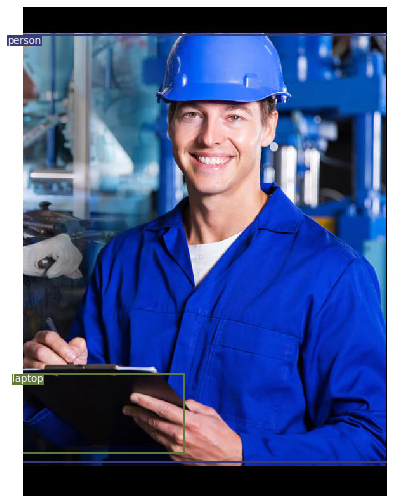

In [0]:
img_path = "/content/1.jpeg"
prev_time = time.time()
img = Image.open(img_path)
img1 = img
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - prev_time)
print ('Inference Time: %s' % (inference_time))

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size * 1.2 / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size * 1.2 / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)
    # browse detections and draw bounding boxes
    ctr = 0
    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
        print(x1)
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        if classes[int(cls_pred)] == 'person':
          out_image = img1.crop((x1.item(),y1.item(),x1.item()+box_w.item(), y1.item()+box_h.item()))
          out_image.save(str(ctr)+'.jpg')
          ctr+=1
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        
        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
plt.axis('off')
plt.show()

In [3]:
!pip install facenet_pytorch

     |████████████████████████████████| 1.9MB 100kB/s 


In [0]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [0]:
mtcnn = MTCNN(keep_all=True, device=device)


In [0]:
img1 = Image.open('/content/drive/My Drive/DataSet/S0G0H0/310.jpg')
img1 = img1.transpose(Image.ROTATE_270)
boxes, _ = mtcnn.detect(img1)
img1.save('1.jpg')
x = boxes[0][0]
y = boxes[0][1]
w = abs(boxes[0][0]-boxes[0][2])
h = abs(boxes[0][1]-boxes[0][3])
x1 = int(x - x * 0.3) 
y1 = int(y - 0.8 * y) 
x2 = int(x+w + 0.1 * (x+w)) 
y2 = int(y + h + 0.2 * (y + h))
out_image_face = img1.crop(boxes[0])
out_image = img1.crop((x1,y1,x2,y2))
out_image.save('0_0.jpg')

In [0]:
len(boxes)

1

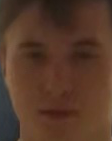

In [0]:
out_image_face

In [0]:
from fastai.vision import  *


In [0]:
from fastai.callbacks.hooks import *

In [0]:
img = open_image('0_0.jpg')

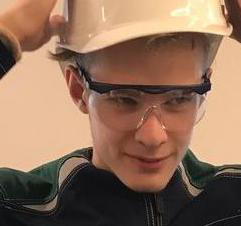

In [0]:
img

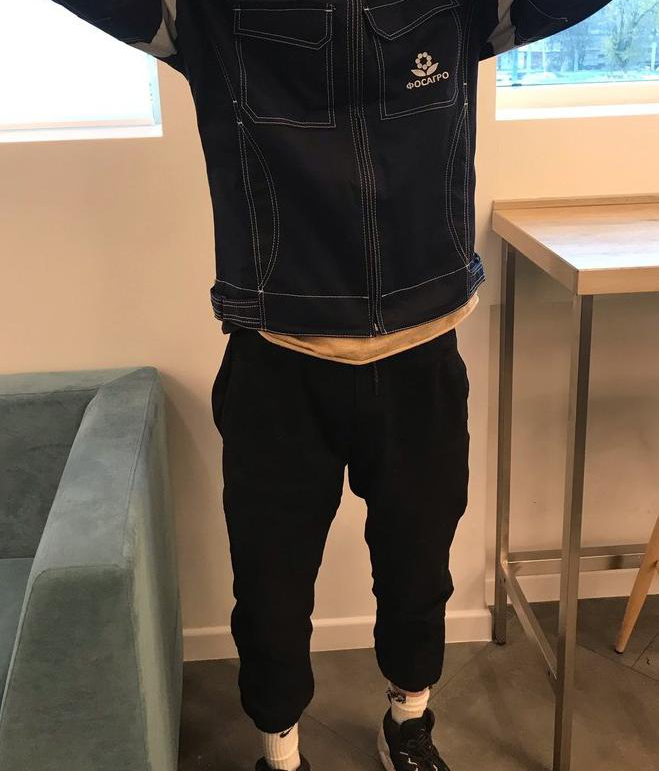

In [0]:
img1.crop((0, y2, img1.size[0], img1.size[1]))

In [0]:
import cv2

In [0]:
!mkdir tmp

mkdir: cannot create directory ‘tmp’: File exists


In [0]:
ls


0_0.jpg                                  night-det.jpg
0.jpg                                    night.jpg
14.5-det.jpg                             object_tracker.py
14.5.jpg                                 oXfAHx-VuF0-det.jpg
1.jpg                                    oXfAHx-VuF0.jpg
1Rxl9P753V4.jpg                          parse_config.py
2cW_Zrs9B_4-det.jpg                      __pycache__/
2cW_Zrs9B_4.jpg                          qnrf_scale_4_epoch_46_weights.pth
3159-det.jpg                             sample_data/
3159.jpg                                 scale_1200.webp
4lmW1K5lCdc-det.jpg                      sort.py
4lmW1K5lCdc.jpg                          tmp/
6T7cQsDh5SU.jpg                          tmp1Rxl9P753V4.jpg/
7kyMvXya2Sw.jpg                          utils.py
aVXMSXRJyQs.jpg                          UVawZ0mEk1Q.jpg
coco.data                                yolov3.cfg
coco.names                               yolov3-tiny.cfg
datasets.py                              yolov3.

In [9]:
!python /content/extract_person_from_frame.py --input=DataSet/S0G0H0/310.jpg --output=DataSet/Train/TrainGlasses/G0Cropped/


Namespace(class_path='coco.names', config_path='yolov3.cfg', input='DataSet/S0G0H0/310.jpg', output='DataSet/Train/TrainGlasses/G0Cropped/', weights_path='yolov3.weights.1')
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
Inference Time: 0:00:01.943988
tensor(164.2406, device='cuda:0')
<Figure size 640x480 with 0 Axes>
<Figure size 1200x900 with 1 Axes>
Running on device: cuda:0
Boxes: [[200.6632744   53.94483455 315.83093727 199.7023865 ]]


In [1]:


!pip install mmcv

In [0]:
import mmcv, cv2
from PIL import Image, ImageDraw
from IPython import display

In [0]:

video = mmcv.VideoReader('IMG_6662.mov')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

display.Video('IMG_6662.mov', width=640)

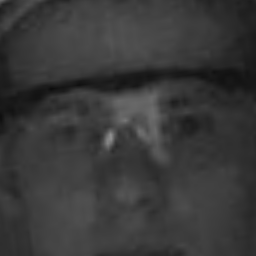

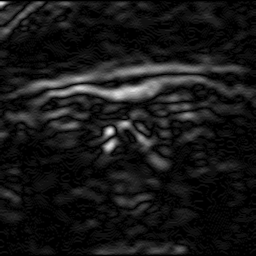

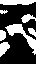

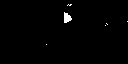

0.09994710286458335
False


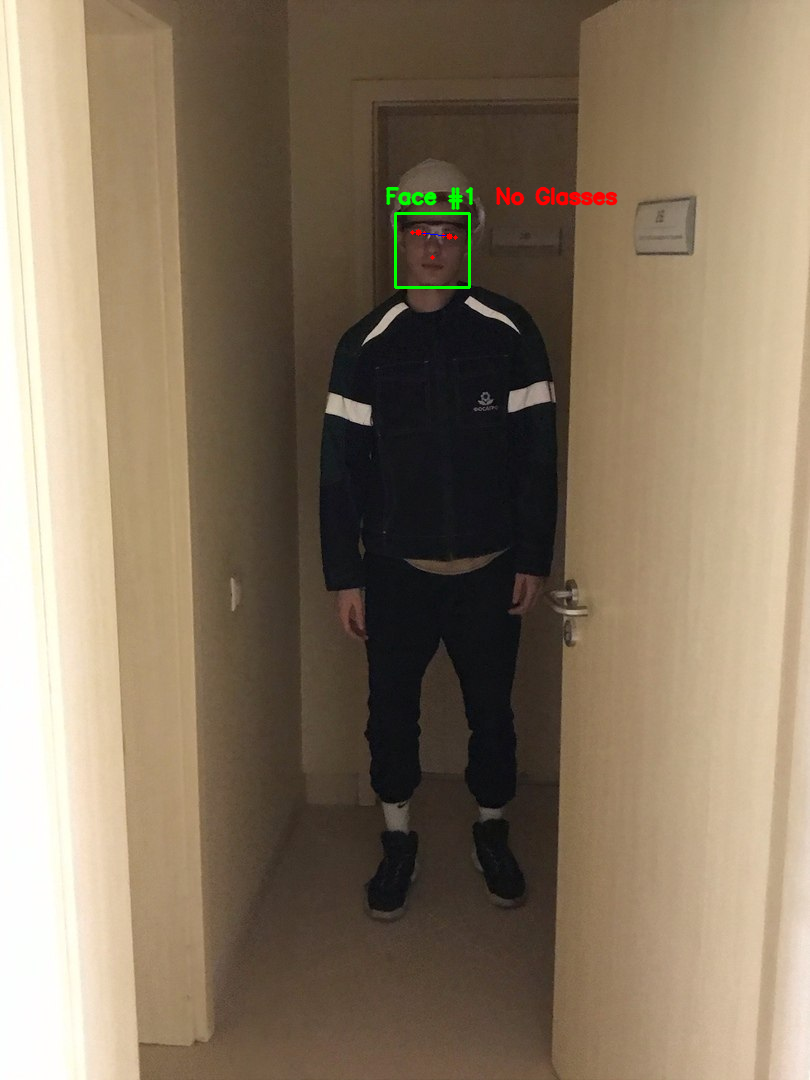

In [0]:
mkdir video

In [0]:
func('123','/content/IMG_6662.mov',5)

In [4]:
!python /content/extract_person_from_frame.py --input=DataSet/S0G0H0/1010.jpg --output=DataSet/S0G0H0_croped/


Namespace(class_path='coco.names', config_path='yolov3.cfg', input='DataSet/S0G0H0/1010.jpg', output='DataSet/S0G0H0_croped/', weights_path='yolov3.weights')
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
Traceback (most recent call last):
  File "/content/extract_person_from_frame.py", line 44, in <module>
    model.load_weights(weights_path)
  File "/content/models.py", line 318, in load_weights
    conv_w = torch.from_numpy(weights[ptr : ptr + num_w]).view_as(conv_layer.weight)
RuntimeError: shape '[512, 256, 3, 3]' is invalid for input of size 439707


In [0]:
import os
from tqdm import tqdm
for (dirpath, dirnames, filenames) in os.walk("/content/drive/My Drive/DataSet/BadS1G0H1"):
    for filename in tqdm(filenames):
      filename = "DataSet/BadS1G0H1/"+filename

      os.system(f"python /content/extract_person_from_frame.py --input={ filename} --output=DataSet/Train/TrainStuff/S1/")
        

100%|██████████| 121/121 [12:03<00:00,  5.93s/it]


In [0]:
import os
from tqdm import tqdm
for (dirpath, dirnames, filenames) in os.walk("/content/drive/My Drive/DataSet/S0G0H0"):
    for filename in tqdm(filenames):
      filename = "DataSet/S0G0H0/"+filename
      os.system(f"python /content/extract_person_from_frame.py --input={ filename} --output=DataSet/Train/TrainStuff/S0/")
        

100%|██████████| 100/100 [10:00<00:00,  5.95s/it]


In [1]:
import os
from tqdm import tqdm
for (dirpath, dirnames, filenames) in os.walk("/content/drive/My Drive/DataSet/Random"):
    for filename in tqdm(filenames):
      filename = "DataSet/Random/"+filename
      os.system(f"python /content/extract_person_from_frame.py --input={ filename} --output=DataSet/Train/TrainStuff/S0/")
        

100%|██████████| 192/192 [18:18<00:00,  5.67s/it]


In [0]:
import os
from tqdm import tqdm
for (dirpath, dirnames, filenames) in os.walk("/content/drive/My Drive/DataSet/S1G0H0"):
    for filename in tqdm(filenames):
      filename = "DataSet/S1G0H0/"+filename
      os.system(f"python /content/extract_person_from_frame.py --input={ filename} --output=DataSet/Train/TrainStuff/S1/")
        

100%|██████████| 109/109 [10:46<00:00,  5.90s/it]


In [0]:
import os
from tqdm import tqdm
for (dirpath, dirnames, filenames) in os.walk("/content/drive/My Drive/DataSet/S1G1H0"):
    for filename in tqdm(filenames):
      filename = "DataSet/S1G1H0/"+filename
      os.system(f"python /content/extract_person_from_frame.py --input={filename} --output=DataSet/Train/TrainStuff/S1/")

 95%|█████████▍| 90/95 [08:53<00:29,  5.95s/it]

In [0]:
import os
from tqdm import tqdm
for (dirpath, dirnames, filenames) in os.walk("/content/drive/My Drive/DataSet/S1G0H1"):
    for filename in tqdm(filenames):
      filename = "DataSet/S1G0H1/"+filename
      os.system(f"python /content/extract_person_from_frame.py --input={filename} --output=DataSet/Train/TrainStuff/S1/123")

 26%|██▌       | 34/130 [02:51<05:45,  3.59s/it]

In [1]:
import os
from tqdm import tqdm
for (dirpath, dirnames, filenames) in os.walk("/content/drive/My Drive/DataSet/S1G1H1"):
    for filename in tqdm(filenames):
      filename = "DataSet/S1G1H1/"+filename
      os.system(f"python /content/extract_person_from_frame.py --input={filename} --output=DataSet/Train/TrainStuff/S1/")

100%|██████████| 187/187 [19:29<00:00,  6.17s/it]


In [0]:
import os
from tqdm import tqdm
for (dirpath, dirnames, filenames) in os.walk("/content/drive/My Drive/DataSet/BadS1G1H1"):
    for filename in tqdm(filenames):
      filename = "DataSet/BadS1G1H1/"+filename
      os.system(f"python /content/extract_person_from_frame.py --input={filename} --output=DataSet/Train/TrainStuff/S1/")

 37%|███▋      | 74/201 [07:33<09:50,  4.65s/it]

In [0]:
import os
from tqdm import tqdm
for (dirpath, dirnames, filenames) in os.walk("/content/drive/My Drive/DataSet/Camera4"):
    for filename in tqdm(filenames):
      filename = "DataSet/Camera4/"+filename
      os.system(f"python /content/extract_person_from_frame.py --input={filename} --output=DataSet/Train/TrainGlasses/G0Cropped/")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
